# Image Preprocessing for Sheep Detection

In [42]:
%pip install opencv-python numpy matplotlib 

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [43]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Load Image and Convert to Grayscale

The images are converted to grayscale so the different preprocessing can be applied.

In [44]:
def load_image(path: str) -> np.ndarray:
    """Load an image in grayscale from a file path."""
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError(f"Image not found: {path}")
    return image

def plot_images(images: list):
    fig, axes = plt.subplots(1, len(images), figsize=(5 * len(images), 5))

    if len(images) == 1:
        axes = [axes]

    for ax, gray, idx in zip(axes, images, range(1, len(images)+1)):
        ax.imshow(gray, cmap='gray')
        ax.set_title(f'Image {idx}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [45]:
ROOT_FOLDER = ".."
DATASET_FOLDER = f"{ROOT_FOLDER}/dataset"
ORIGINAL_IMAGE_FOLDER = f"{DATASET_FOLDER}/images/original"
ENHANCED_IMAGE_FOLDER = f"{DATASET_FOLDER}/images/enhanced"

example_images = [
    'DJI_20240125160526_0002_T.JPG',
    'DJI_20240125160538_0008_T.JPG', 
    'DJI_20240125160618_0028_T.JPG', 
    'DJI_20240125160820_0089_T.JPG',
    'DJI_20240125160808_0083_T.JPG'
]

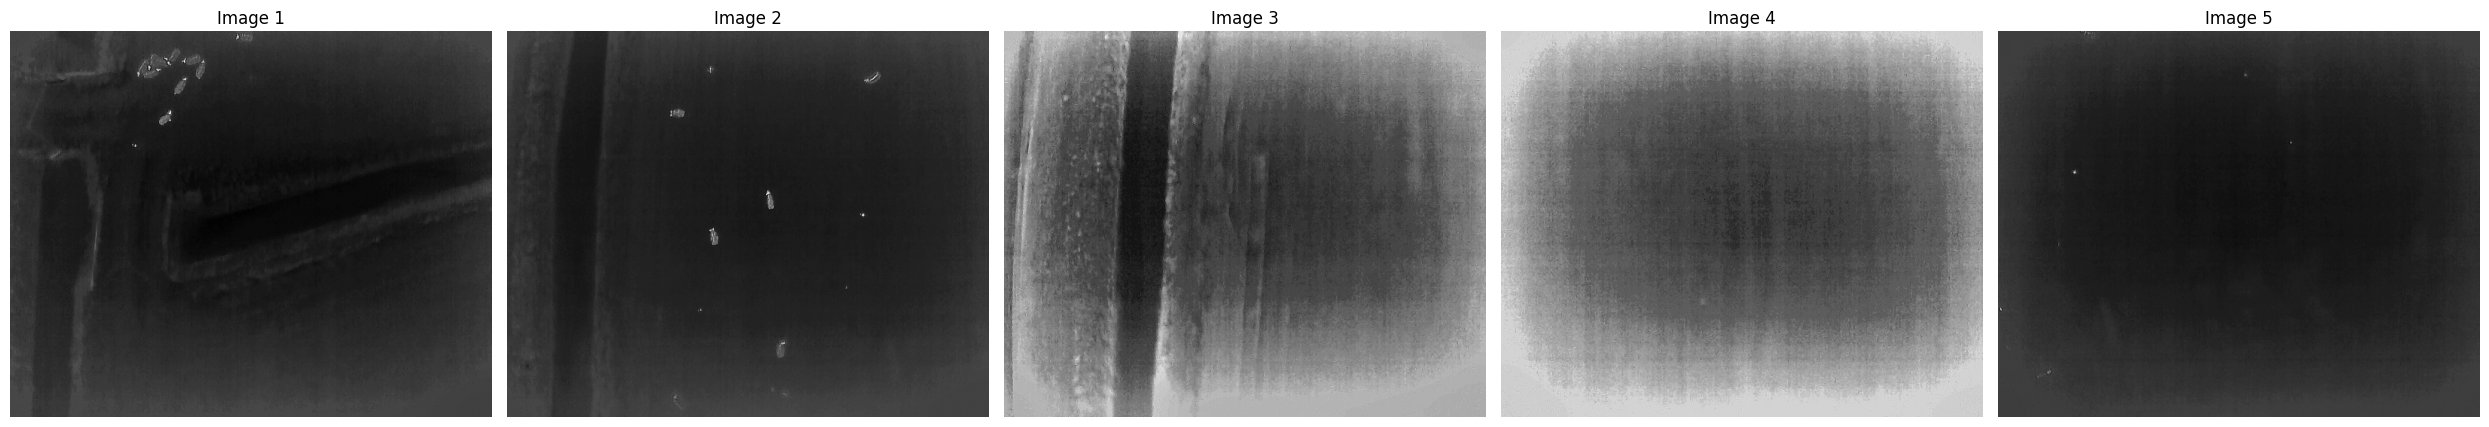

In [46]:

gray_images = [load_image(f'{ORIGINAL_IMAGE_FOLDER}/{img_name}') for img_name in example_images]
plot_images(gray_images)

## Remove Vignette

You can see in the images they have a focus in the middle and then a fading noise on the sides. This is likely cuased by the camera lens.

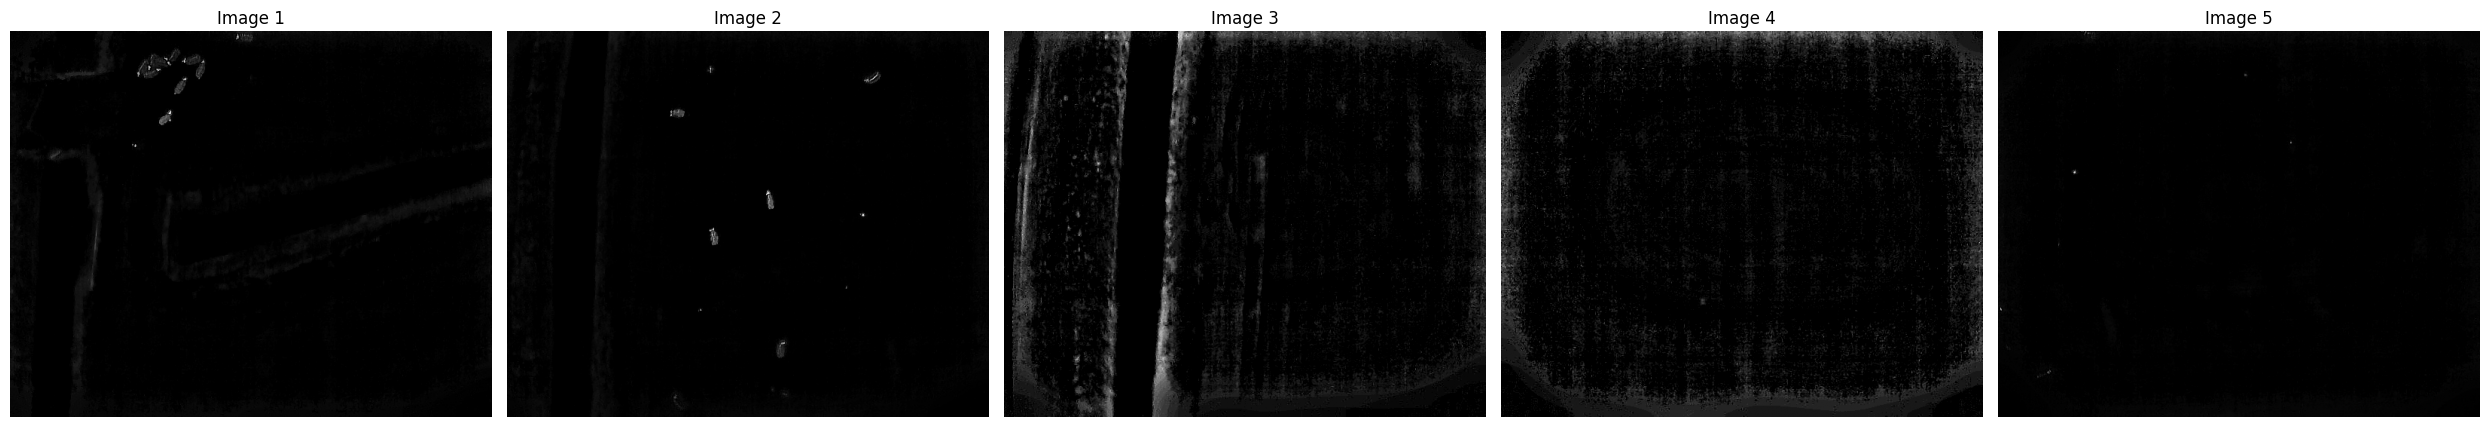

In [51]:
def remove_vignette(img: np.ndarray) -> np.ndarray:
    """Correct vignetting by subtracting a blurred version of the image (remove uneven illumination)."""
    # Create a very blurred version of the image to approximate lighting falloff
    background = cv2.GaussianBlur(img, (201, 201), 0)
    # Subtract the background lighting from the original image
    corrected = cv2.subtract(img, background)
    return corrected


images_without_vignette = [remove_vignette(img) for img in gray_images]
plot_images(images_without_vignette)

## Remove Noise

Some of the images still have some kind of noise before we can train the model this needs to be removed.

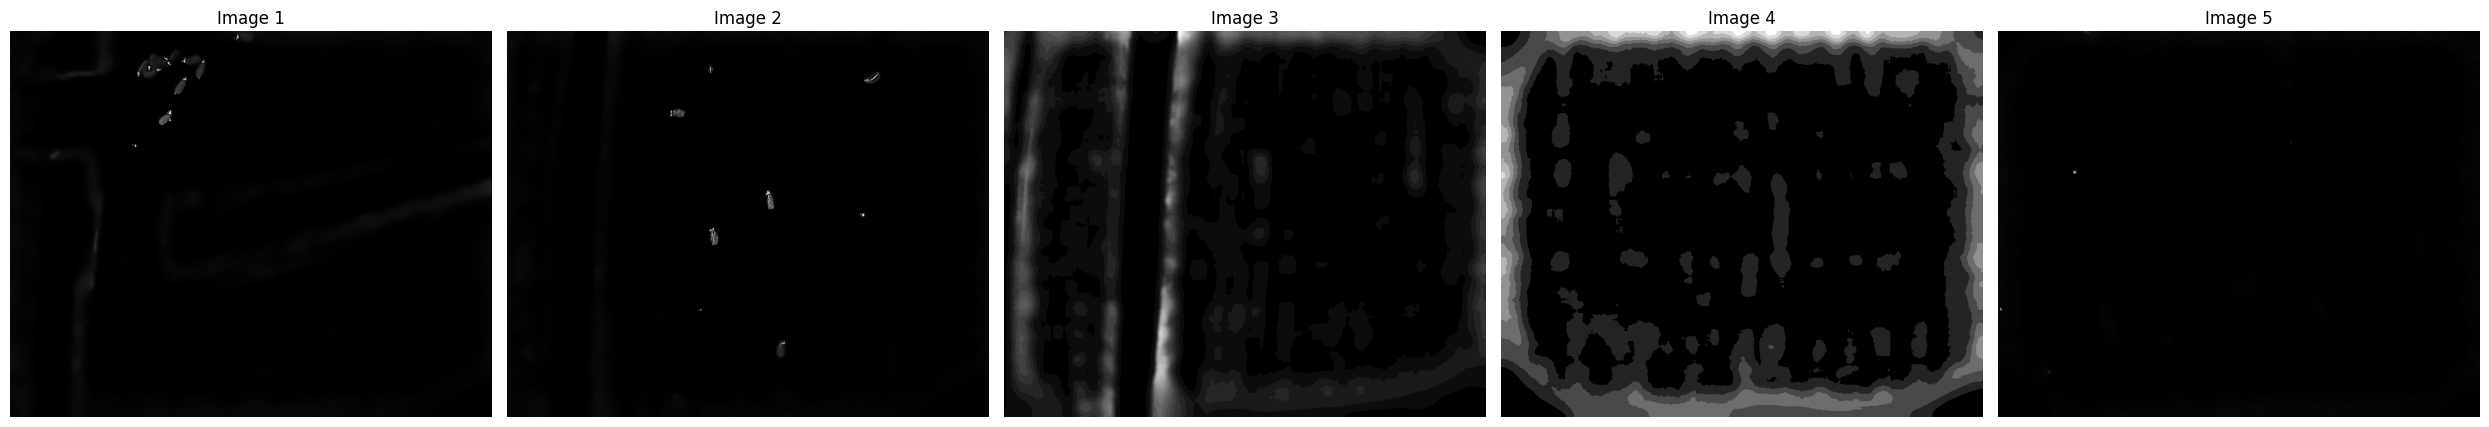

In [52]:
def remove_noise(img: np.ndarray) -> np.ndarray:
    """Apply noise reduction using Non-local Means Denoising."""
    # h=10 is the filter strength for the noise removal; adjust as needed for balance between noise and detail
    denoised = cv2.fastNlMeansDenoising(img, h=10)
    return denoised

images_without_noise = [remove_noise(img) for img in images_without_vignette]
plot_images(images_without_noise)

## Enhance detail

To really let the sheep stick out we can apply CLAHE to increase details.

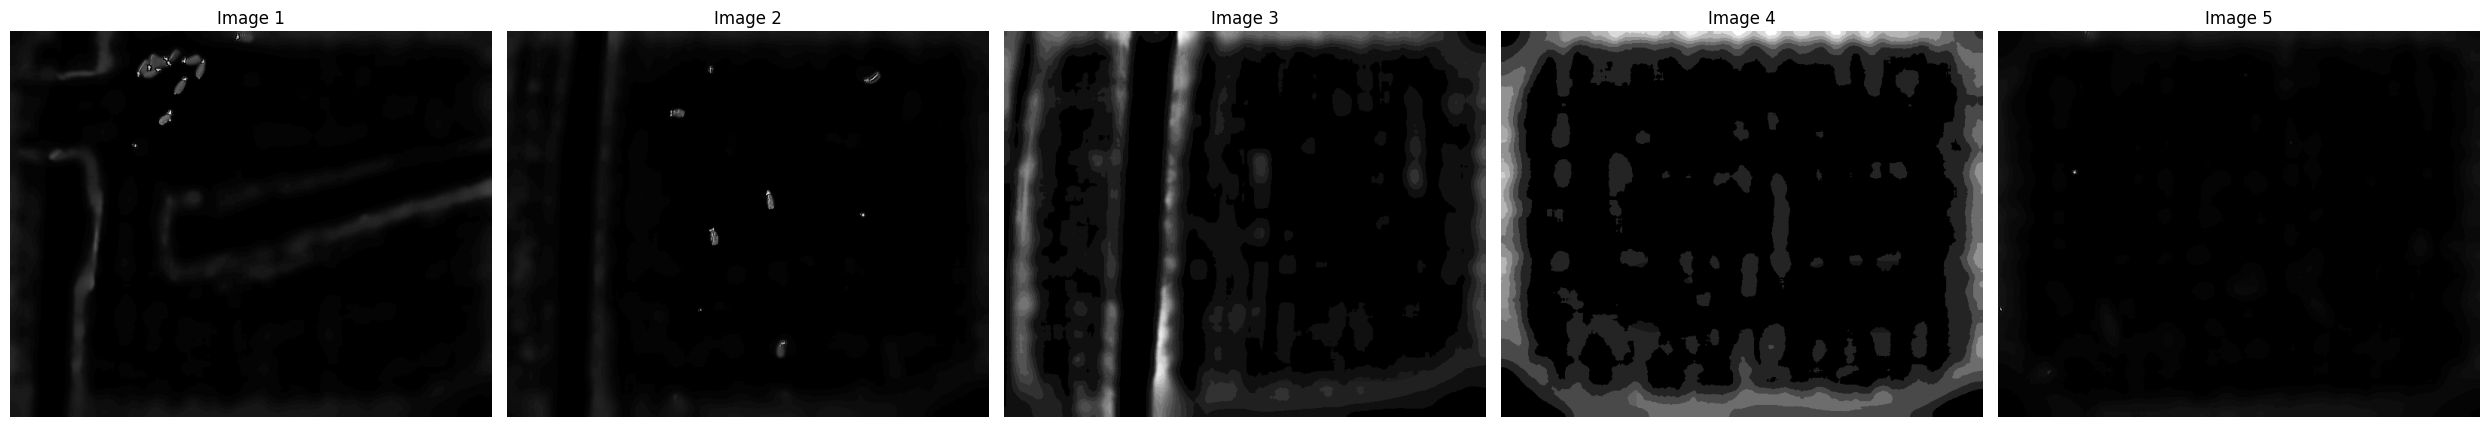

In [53]:
def apply_clahe(img: np.ndarray) -> np.ndarray:
    """Boost local contrast using CLAHE (optional; can introduce noise)."""
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(img)

    
clahe_images = [apply_clahe(img) for img in images_without_noise]
plot_images(clahe_images)

As you can see the images really improve when removing the vignette which is caused by the camera. But you can see the improvements are smaller on images without any sheep. This can be caused by different types of lightning, which means this are not original infra red images.

In [ ]:
os.makedirs(ENHANCED_IMAGE_FOLDER, exist_ok=True)

def enhance_image(path: str) -> np.ndarray:
    """Apply the full enhancement pipeline to an image file path."""
    gray = load_image(path)
    corrected = remove_vignette(gray)
    denoised = remove_noise(corrected)
    return denoised

# Process each image in the dataset
for image_name in os.listdir(ORIGINAL_IMAGE_FOLDER):
    input_path = os.path.join(ORIGINAL_IMAGE_FOLDER, image_name)
    output_path = os.path.join(ENHANCED_IMAGE_FOLDER, image_name)
    try:
        processed = enhance_image(input_path)
        # Save the enhanced image. Convert back to 3-channel BGR so it can be saved as color (optional).
        cv2.imwrite(output_path, cv2.cvtColor(processed, cv2.COLOR_GRAY2BGR))
    except Exception as e:
        print(f"Skipping {image_name}: {e}")